In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from torch.nn import functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm


In [33]:
device ='cuda:4' if torch.cuda.is_available() else 'cpu'
device

'cuda:4'

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset,random_split
from torchvision.transforms import ToTensor
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from PIL import Image
import glob
import os


In [16]:
# img=Image.open('/raid/biplab/shabnam/Satmae/SatMAE/srcnn/micdata/highresdata/highimg_3_32.png').convert('RGB')
# img=transform(img)
# img.shape


In [17]:

class MRIDataset(Dataset):
    def __init__(self, low_res_dir, high_res_dir, transform=None):
        self.low_res_paths = sorted(glob.glob(low_res_dir + '/*.png'))
        self.high_res_paths = sorted(glob.glob(high_res_dir + '/*.png'))
        self.transform = transform

    def __len__(self):
        return len(self.low_res_paths)

    def __getitem__(self, idx):
        low_res_image = Image.open(self.low_res_paths[idx]).convert('RGB')
        high_res_image = Image.open(self.high_res_paths[idx]).convert('RGB')

        if self.transform:
            low_res_image = self.transform(low_res_image)
            # print(low_res_image.shape)
            high_res_image = self.transform(high_res_image)

        return low_res_image, high_res_image


In [18]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        identity = x
        out = self.prelu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return identity + out

class Generator(nn.Module):
    def __init__(self, in_channels=3, num_residual_blocks=16):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4)
        self.prelu = nn.PReLU()
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(64) for _ in range(num_residual_blocks)]
        )
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.upsample1 = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU()
        )
        self.upsample2 = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU()
        )
        self.conv3 = nn.Conv2d(64, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        out1 = self.prelu(self.conv1(x))
        out = self.residual_blocks(out1)
        out = self.bn2(self.conv2(out))
        out = out1 + out
        out = self.upsample1(out)
        # out = self.upsample2(out)
        out = self.conv3(out)
        return out



In [19]:
s=Generator()
x=torch.rand(5,3,128,128)
k=s(x)
print(k.shape)

torch.Size([5, 3, 256, 256])


In [20]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        self.block5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        self.block6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        self.block7 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        )
        self.block8 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        )
        self.fc1 = nn.Linear(512 * 16 * 16, 1024)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(1024, 1)

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        out = self.block7(out)
        out = self.block8(out)
        out = out.view(out.size(0), -1)
        out = self.leaky_relu(self.fc1(out))
        out = self.fc2(out)
        out=F.sigmoid(out)
        return out

      


In [21]:
d=Discriminator()
z=d(k)
z

tensor([[0.5085],
        [0.4639],
        [0.5004],
        [0.5274],
        [0.4267]], grad_fn=<SigmoidBackward0>)

In [56]:
transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset =MRIDataset(low_res_dir=r'/home/shivang/mic/micdata/lowresdata', high_res_dir=r'/home/shivang/mic/micdata/highresdata', transform=transform)
train_size=int(len(dataset)*0.9)
val_size=len(dataset)-train_size
train_dataset,val_dataset=random_split(dataset,[train_size,val_size])
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
print(len(train_dataloader))

998


In [57]:
adversarial_loss = nn.BCEWithLogitsLoss()
content_loss = nn.MSELoss()

generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))


In [58]:
load=True
if(load):
    checkpointgen = torch.load('/home/shivang/mic/generatorsrgan.pth',map_location=device)
    checkpointdis = torch.load('/home/shivang/mic/discriminatorsrgan.pth',map_location=device)
    print(checkpointgen.keys())
    generator.load_state_dict(checkpointgen)
    discriminator.load_state_dict(checkpointdis)

/tmp/ipykernel_916284/1843636583.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpointgen = torch.load('/home/shivang/mic/generatorsrgan.pth',map_location=device)
/

odict_keys(['conv1.weight', 'conv1.bias', 'prelu.weight', 'residual_blocks.0.conv1.weight', 'residual_blocks.0.conv1.bias', 'residual_blocks.0.bn1.weight', 'residual_blocks.0.bn1.bias', 'residual_blocks.0.bn1.running_mean', 'residual_blocks.0.bn1.running_var', 'residual_blocks.0.bn1.num_batches_tracked', 'residual_blocks.0.prelu.weight', 'residual_blocks.0.conv2.weight', 'residual_blocks.0.conv2.bias', 'residual_blocks.0.bn2.weight', 'residual_blocks.0.bn2.bias', 'residual_blocks.0.bn2.running_mean', 'residual_blocks.0.bn2.running_var', 'residual_blocks.0.bn2.num_batches_tracked', 'residual_blocks.1.conv1.weight', 'residual_blocks.1.conv1.bias', 'residual_blocks.1.bn1.weight', 'residual_blocks.1.bn1.bias', 'residual_blocks.1.bn1.running_mean', 'residual_blocks.1.bn1.running_var', 'residual_blocks.1.bn1.num_batches_tracked', 'residual_blocks.1.prelu.weight', 'residual_blocks.1.conv2.weight', 'residual_blocks.1.conv2.bias', 'residual_blocks.1.bn2.weight', 'residual_blocks.1.bn2.bias', 'r

In [32]:

from math import inf
epochs = 100

g_best=float(inf)
d_best=float(inf)

for epoch in range(epochs):
    for i, (low_res, high_res) in enumerate(tqdm(train_dataloader)):
        valid = torch.ones((low_res.size(0), 1), requires_grad=False).to(device)
        fake = torch.zeros((low_res.size(0), 1), requires_grad=False).to(device)
        
        high_res = high_res.to(device)
        low_res = low_res.to(device)
        # print(low_res.shape)
        # print(high_res.shape)
        # Train Generator
        optimizer_G.zero_grad()

        gen_high_res = generator(low_res)
        validity = discriminator(gen_high_res)
        g_loss = content_loss(gen_high_res, high_res) + 1e-3 * adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()

        real_loss = adversarial_loss(discriminator(high_res), valid)
        fake_loss = adversarial_loss(discriminator(gen_high_res.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()
    
    print(f"Epoch [{epoch}/{epochs}]  D loss: {d_loss.item()}  G loss: {g_loss.item()}")
    generator.eval()
    psnr_values = []

    with torch.no_grad():
        for low_res, high_res in tqdm(val_dataloader):
            low_res = low_res.to(device)
            high_res = high_res.to(device)
            gen_high_res = generator(low_res)
            psnr_value = psnr(high_res.cpu().numpy(), gen_high_res.cpu().numpy())
            psnr_values.append(psnr_value)

    avg_psnr = np.mean(psnr_values)
    print(f'Average PSNR: {avg_psnr}')
    if(d_loss<d_best):
        d_best=d_loss
        torch.save(discriminator.state_dict(), f'discriminatorsrgan.pth')
        print("Saved")
    if(g_loss<g_best):
        g_best=g_loss
        torch.save(generator.state_dict(), f'generatorsrgan.pth')   
        print("Saved") 

    
 
    

100%|██████████| 998/998 [11:32<00:00,  1.44it/s]


Epoch [0/100]  D loss: 0.6931471824645996  G loss: 0.0016766529297456145


100%|██████████| 111/111 [00:19<00:00,  5.73it/s]


Average PSNR: 31.24012158297582
Saved
Saved


100%|██████████| 998/998 [11:25<00:00,  1.46it/s]


Epoch [1/100]  D loss: 0.6931471824645996  G loss: 0.001643422874622047


100%|██████████| 111/111 [00:19<00:00,  5.58it/s]


Average PSNR: 29.423742274106193
Saved


100%|██████████| 998/998 [11:25<00:00,  1.46it/s]


Epoch [2/100]  D loss: 0.6931471824645996  G loss: 0.0018136814469471574


100%|██████████| 111/111 [00:19<00:00,  5.58it/s]


Average PSNR: 28.88921367356525


100%|██████████| 998/998 [11:25<00:00,  1.46it/s]


Epoch [3/100]  D loss: 0.6931471824645996  G loss: 0.0015953835099935532


100%|██████████| 111/111 [00:19<00:00,  5.67it/s]


Average PSNR: 30.86266917298423
Saved


100%|██████████| 998/998 [11:28<00:00,  1.45it/s]


Epoch [4/100]  D loss: 0.6931471824645996  G loss: 0.0013634907081723213


100%|██████████| 111/111 [00:19<00:00,  5.63it/s]


Average PSNR: 30.54990440564681
Saved


100%|██████████| 998/998 [11:36<00:00,  1.43it/s]


Epoch [5/100]  D loss: 0.6931471824645996  G loss: 0.0014760238118469715


100%|██████████| 111/111 [00:19<00:00,  5.59it/s]


Average PSNR: 31.40577520062508


100%|██████████| 998/998 [11:36<00:00,  1.43it/s]


Epoch [6/100]  D loss: 0.6931471824645996  G loss: 0.0015487547498196363


100%|██████████| 111/111 [00:19<00:00,  5.56it/s]


Average PSNR: 28.560763005407697


100%|██████████| 998/998 [11:36<00:00,  1.43it/s]


Epoch [7/100]  D loss: 0.6931471824645996  G loss: 0.0014574292581528425


100%|██████████| 111/111 [00:19<00:00,  5.71it/s]


Average PSNR: 28.599374379159656


100%|██████████| 998/998 [11:35<00:00,  1.43it/s]


Epoch [8/100]  D loss: 0.6931471824645996  G loss: 0.0013749019708484411


100%|██████████| 111/111 [00:19<00:00,  5.64it/s]


Average PSNR: 31.932398969160936


100%|██████████| 998/998 [11:35<00:00,  1.43it/s]


Epoch [9/100]  D loss: 0.6931471824645996  G loss: 0.0015236918115988374


100%|██████████| 111/111 [00:19<00:00,  5.67it/s]


Average PSNR: 31.984211099807716


100%|██████████| 998/998 [11:35<00:00,  1.43it/s]


Epoch [10/100]  D loss: 0.6931471824645996  G loss: 0.0013623206177726388


100%|██████████| 111/111 [00:20<00:00,  5.53it/s]


Average PSNR: 31.005439661111893
Saved


100%|██████████| 998/998 [11:36<00:00,  1.43it/s]


Epoch [11/100]  D loss: 0.6931471824645996  G loss: 0.0012662175577133894


100%|██████████| 111/111 [00:19<00:00,  5.67it/s]


Average PSNR: 31.83226436176969
Saved


100%|██████████| 998/998 [11:36<00:00,  1.43it/s]


Epoch [12/100]  D loss: 0.6931471824645996  G loss: 0.0012490192893892527


100%|██████████| 111/111 [00:19<00:00,  5.61it/s]


Average PSNR: 32.376236715251125
Saved


100%|██████████| 998/998 [11:36<00:00,  1.43it/s]


Epoch [13/100]  D loss: 0.6931471824645996  G loss: 0.01142300758510828


100%|██████████| 111/111 [00:20<00:00,  5.55it/s]


Average PSNR: 19.30010092462383


100%|██████████| 998/998 [11:35<00:00,  1.44it/s]


Epoch [14/100]  D loss: 0.6931471824645996  G loss: 0.005124096758663654


100%|██████████| 111/111 [00:19<00:00,  5.56it/s]


Average PSNR: 24.35708758789127


100%|██████████| 998/998 [11:35<00:00,  1.44it/s]


Epoch [15/100]  D loss: 0.6931471824645996  G loss: 0.004018472041934729


100%|██████████| 111/111 [00:19<00:00,  5.61it/s]


Average PSNR: 25.876167639108534


100%|██████████| 998/998 [11:34<00:00,  1.44it/s]


Epoch [16/100]  D loss: 0.6931471824645996  G loss: 0.002545672934502363


100%|██████████| 111/111 [00:19<00:00,  5.58it/s]


Average PSNR: 26.87058426216846


100%|██████████| 998/998 [11:34<00:00,  1.44it/s]


Epoch [17/100]  D loss: 0.6931471824645996  G loss: 0.002255797851830721


100%|██████████| 111/111 [00:19<00:00,  5.72it/s]


Average PSNR: 27.811345458297904


100%|██████████| 998/998 [11:34<00:00,  1.44it/s]


Epoch [18/100]  D loss: 0.6931471824645996  G loss: 0.001813438138924539


100%|██████████| 111/111 [00:19<00:00,  5.69it/s]


Average PSNR: 28.686278819696977


100%|██████████| 998/998 [11:35<00:00,  1.44it/s]


Epoch [19/100]  D loss: 0.6931471824645996  G loss: 0.0015401141718029976


100%|██████████| 111/111 [00:19<00:00,  5.58it/s]


Average PSNR: 29.539429675695857


100%|██████████| 998/998 [11:34<00:00,  1.44it/s]


Epoch [20/100]  D loss: 0.6931471824645996  G loss: 0.0015308910515159369


100%|██████████| 111/111 [00:19<00:00,  5.59it/s]


Average PSNR: 30.052929904106534


100%|██████████| 998/998 [11:34<00:00,  1.44it/s]


Epoch [21/100]  D loss: 0.6931471824645996  G loss: 0.0014874974731355906


100%|██████████| 111/111 [00:19<00:00,  5.57it/s]


Average PSNR: 30.63592696002826


100%|██████████| 998/998 [11:34<00:00,  1.44it/s]


Epoch [22/100]  D loss: 0.6931471824645996  G loss: 0.0016914510633796453


100%|██████████| 111/111 [00:19<00:00,  5.71it/s]


Average PSNR: 29.85513439720844


100%|██████████| 998/998 [11:34<00:00,  1.44it/s]


Epoch [23/100]  D loss: 0.6931471824645996  G loss: 0.001811555353924632


100%|██████████| 111/111 [00:19<00:00,  5.65it/s]


Average PSNR: 29.71379903206814


100%|██████████| 998/998 [11:35<00:00,  1.44it/s]


Epoch [24/100]  D loss: 0.6931471824645996  G loss: 0.0012131133116781712


100%|██████████| 111/111 [00:19<00:00,  5.57it/s]


Average PSNR: 30.88110792781996
Saved


100%|██████████| 998/998 [11:34<00:00,  1.44it/s]


Epoch [25/100]  D loss: 0.6931471824645996  G loss: 0.0012362687848508358


100%|██████████| 111/111 [00:19<00:00,  5.57it/s]


Average PSNR: 31.564611455980074


 18%|█▊        | 178/998 [02:03<09:29,  1.44it/s]

In [38]:
def plot_sample_images(low_res, high_res, generated):
    plt.figure(figsize=(12, 12))
    for i in range(3):
        plt.subplot(3, 3, i + 1)
        plt.imshow(low_res[i+5].permute(1, 2, 0).cpu().numpy())
        plt.title('Low Resolution')
        plt.axis('off')

        plt.subplot(3, 3, i + 4)
        plt.imshow(generated[i+5].permute(1, 2, 0).cpu().detach().numpy())
        plt.title('Generated')
        plt.axis('off')

        plt.subplot(3, 3, i + 7)
        plt.imshow(high_res[i+5].permute(1, 2, 0).cpu().numpy())
        plt.title('High Resolution')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

100%|██████████| 111/111 [00:17<00:00,  6.49it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Average PSNR: 31.91136438969968


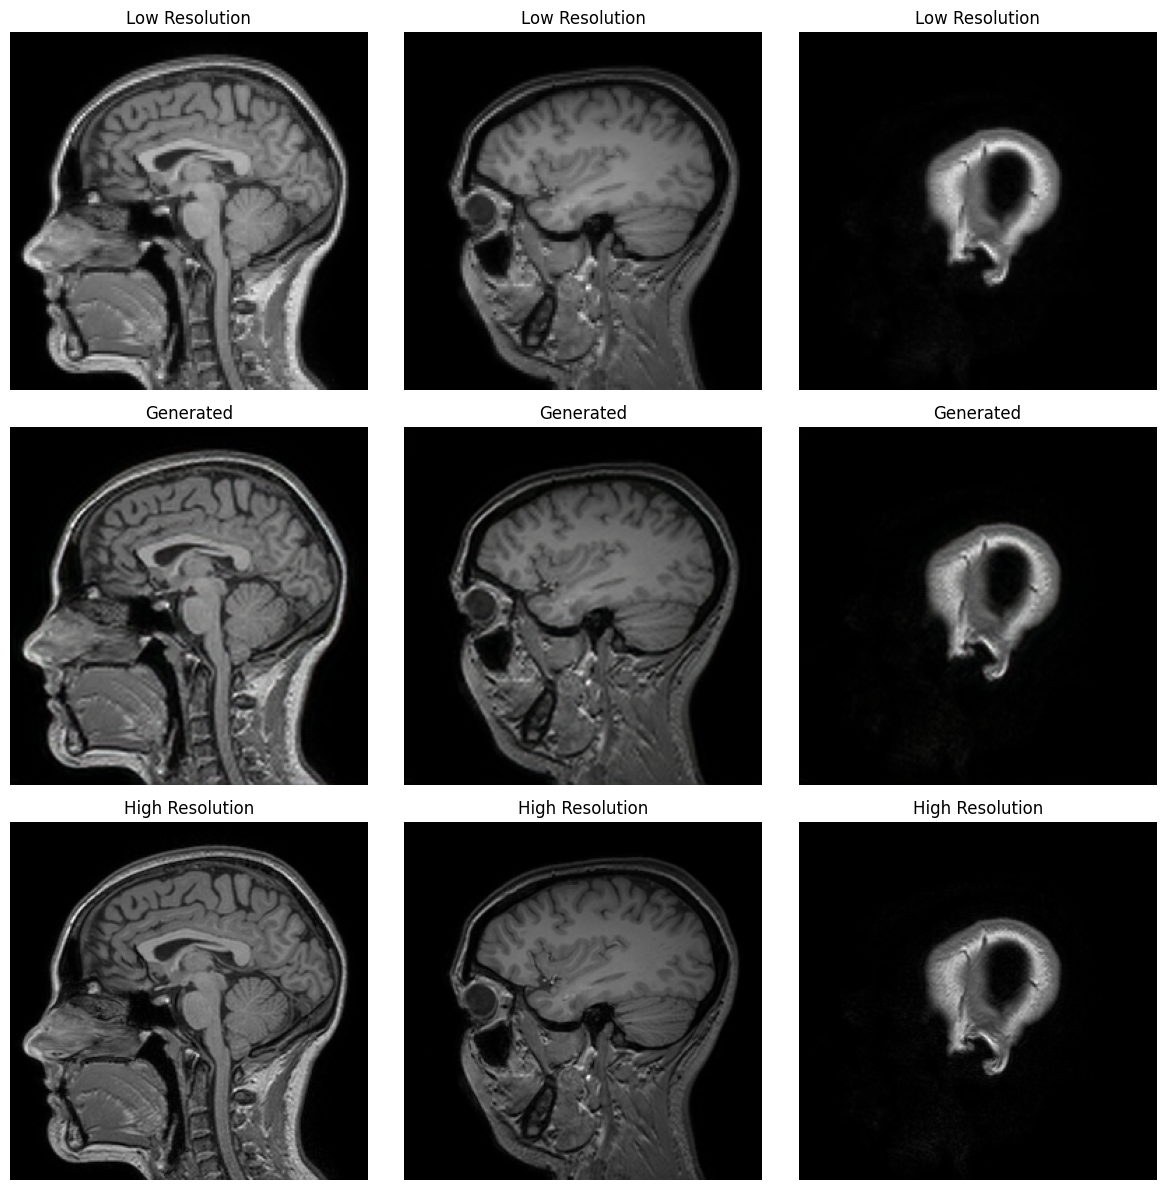

31.91136438969968

In [59]:
def evaluate_model(generator, test_loader):
    generator.eval()
    psnr_values = []

    with torch.no_grad():
        for low_res, high_res in tqdm(test_loader):
            low_res = low_res.to(device)
            high_res = high_res.to(device)

            gen_high_res = generator(low_res)
            psnr_value = psnr(high_res.cpu().numpy(), gen_high_res.cpu().numpy())
            psnr_values.append(psnr_value)

    avg_psnr = np.mean(psnr_values)
    print(f'Average PSNR: {avg_psnr}')
    plot_sample_images(low_res, high_res, gen_high_res)
    return avg_psnr



evaluate_model(generator, val_dataloader)



In [67]:
import glob
import numpy as np
from PIL import Image
import torch
import PIL.Image as pil_image
import os
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure, PeakSignalNoiseRatioWithBlockedEffect
from torchvision import transforms
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image import PeakSignalNoiseRatioWithBlockedEffect
from torchvision.transforms.functional import to_tensor, to_grayscale
from torchmetrics.functional import multiscale_structural_similarity_index_measure
import matplotlib.pyplot as plt
import lpips

import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image, to_tensor

import argparse

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
GPU=4
DIR='/home/shivang/mic/saved_output2'

# import lpips

from torchmetrics.functional import multiscale_structural_similarity_index_measure as ms_ssim

def calculate_ms_ssim(list1, list2):
    c = list1[0].shape[2]
    aggregate_loss = 0.0
    for img1, img2 in zip(list1, list2):
        ms_ssim_values = []
        for i in range(c):  # Loop through each color channel
            tensor1 = torch.tensor(img1[..., i]).unsqueeze(0).unsqueeze(0).float() / 255.0
            tensor2 = torch.tensor(img2[..., i]).unsqueeze(0).unsqueeze(0).float() / 255.0
            ms_ssim_value = ms_ssim(tensor1, tensor2).item()
            ms_ssim_values.append(ms_ssim_value)
        aggregate_loss += np.mean(ms_ssim_values)
    return aggregate_loss / len(list1)

def calculate_mse(list1, list2):
    aggregated_loss = 0.0
    for high_quality_frame, predicted_frame in zip(list1, list2):
        loss = mean_squared_error(high_quality_frame, predicted_frame)
        aggregated_loss += loss
    return aggregated_loss / len(list1)

def calculate_psnr_b(list1, list2):
    c = list1[0].shape[2]
    psnr_b=PeakSignalNoiseRatioWithBlockedEffect()
    aggregate_loss = 0.0
    for img1, img2 in zip(list1, list2):
        psnr_b_values = []
        for i in range(c):  # Loop through each color channel
            tensor1 = torch.tensor(img1[..., i]).unsqueeze(0).unsqueeze(0).float() / 255.0
            tensor2 = torch.tensor(img2[..., i]).unsqueeze(0).unsqueeze(0).float() / 255.0
            psnr_b_value = psnr_b(tensor1, tensor2).item()
            psnr_b_values.append(psnr_b_value)
        aggregate_loss += np.mean(psnr_b_values)
    return aggregate_loss / len(list1)

def calculate_psnr(list1, list2):
    c=list1[0].shape[2]
    aggregate_loss=0.0
    for img1,img2 in zip(list1,list2):
        psnr_values = []
        for i in range(c):  # Loop through each color channel
            mse = np.mean((img1[..., i] - img2[..., i]) ** 2)
            if mse == 0:
                psnr_values.append(float('inf'))
            else:
                PIXEL_MAX = 255.0
                psnr = 20 * np.log10(PIXEL_MAX / np.sqrt(mse))
                psnr_values.append(psnr)

        aggregate_loss+=np.mean(psnr_values)
    return aggregate_loss/len(list1)

def calculate_ssim(list1, list2):
    c=list1[0].shape[2]
    aggregate_loss=0.0
    for img1,img2 in zip(list1,list2):
        ssim_values = []
        for i in range(c):  # Loop through each color channel
            ssim_value, _ = ssim(img1[..., i], img2[..., i], full=True,data_range=255.0)
            ssim_values.append(ssim_value)
        aggregate_loss+=np.mean(ssim_values)
    return aggregate_loss/len(list1)

def predict(model, low_res):
    device = torch.device(f"cuda:{GPU}")
    low_res=low_res.to(device)
    # model.eval()
    # Perform prediction
    with torch.no_grad():
        pred_res = model(low_res)
    
    # print(pred_res.shape)

    # Convert predicted patch to numpy and store in list
    pred_res = pred_res[0].squeeze(0).permute(1,2,0).cpu().detach().numpy()

    # Reconstruct frames from predicted patches
    # print(reconstructed_frame)
    pred_res = np.clip(pred_res * 255, 0, 255).astype(np.uint8)
    # print(result_frame.std(),result_frame.max())
    return pred_res

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params
    return total_params, trainable_params, non_trainable_params

def compute_fid(real_images, fake_images):
    device = torch.device(f"cuda:{GPU}")
    fid_metric = FrechetInceptionDistance().to(device)
    fid_metric.update(real_images, real=True)
    fid_metric.update(fake_images, real=False)
    fid_score = fid_metric.compute()
    return fid_score

def load_image(image):
    if isinstance(image, np.ndarray):  # If the input is a NumPy array
        image = Image.fromarray(image).convert("RGB")
    # Resize to Inception v3 input size
    image = image.resize((299, 299))
    # Convert to tensor and scale to [0, 255]
    image_tensor = to_tensor(image).mul(255).to(torch.uint8)
    device = torch.device(f"cuda:{GPU}")
    return image_tensor.to(device)


def rgb_to_grayscale(rgb_image):
    # Convert NumPy array to PIL Image
    pil_image = Image.fromarray(np.uint8(rgb_image))
    
    # Convert PIL Image to grayscale
    grayscale_pil_image = pil_image.convert('L')
    
    # Convert grayscale PIL Image back to NumPy array
    grayscale_np_image = np.array(grayscale_pil_image)
    
    return grayscale_np_image

def test(model,val_dataloader):
    device = torch.device(f"cuda:{GPU}")
    

    psnr_values_compressed, ssim_values_compressed, psnr_b_values_compressed = [], [], []
    psnr_values_output, ssim_values_output, psnr_b_values_output = [], [], []
    pl_values_compressed, pl_values_output = [], []
    ms_ssim_values_compressed, ms_ssim_values_output = [], []
    original_images = []
    compressed_images = []
    model_output_images = []

    psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    psnr_b_metric = PeakSignalNoiseRatioWithBlockedEffect().to(device)
    lpips_metric = lpips.LPIPS(net='vgg').to(device)
    i=0
    for low_res,high_res in val_dataloader:
        predicted_frame = predict(model, low_res)
        # predicted_frame = predicted_frame.squeeze()
        # print(predicted_frame.shape, predicted_frame.std(), predicted_frame.max())
        
        predicted_img = pil_image.fromarray(predicted_frame, mode='RGB')
        
        low_res = low_res[0].squeeze(0).permute(1, 2, 0).numpy()
        high_res = high_res[0].squeeze(0).permute(1, 2, 0).numpy()
        
        # Resize low_res to match high_res dimensions
        low_res_img = pil_image.fromarray((low_res * 255).astype(np.uint8), mode='RGB')
        high_res_img = pil_image.fromarray((high_res * 255).astype(np.uint8), mode='RGB')
        
        low_res_resized = low_res_img.resize(high_res_img.size, Image.BICUBIC)
        
        directory = DIR + '/images'
        if not os.path.exists(directory):
            os.mkdir(directory)
            
        output_path = directory + "/" + str(i) + '.png'
        predicted_img.save(output_path)
        
        # Convert high_res to uint8
        high_res_uint8 = (high_res * 255).astype(np.uint8)
        
        # Convert to PIL Image
        original_img = pil_image.fromarray(high_res_uint8).convert("RGB")
        
        # Convert low_res to uint8
        low_res_uint8 = (low_res * 255).astype(np.uint8)
        
        # Convert low-resolution array to PIL Image
        compressed_img = pil_image.fromarray(low_res_uint8).convert("RGB")
        
        # Resize the low_res image to match the high_res size
        compressed_img = compressed_img.resize(original_img.size, pil_image.BICUBIC)
        
        # print(compressed_img.size, original_img.size)
        original_images.append(load_image(high_res_uint8))
        compressed_images.append(load_image(low_res_uint8))
        model_output_images.append(load_image(predicted_img))
        # print(predicted_img.size)
        # Convert images to grayscale for PSNR-B metric calculation
        original_gray = to_grayscale(original_img)
        compressed_gray = to_grayscale(compressed_img)
        output_gray = to_grayscale(predicted_img)

        # Convert images to tensors
        # print(compressed_img.size,original_img.size)
        original_tensor = transforms.ToTensor()(original_img).unsqueeze(0).to(device)
        compressed_tensor = transforms.ToTensor()(compressed_img).unsqueeze(0).to(device)
        # print(compressed_tensor.shape,original_tensor.shape)
        output_tensor = transforms.ToTensor()(predicted_img).unsqueeze(0).to(device)
        _, _, h, w = output_tensor.size()
        # print(output_tensor.shape)
        
        # original_tensor = transforms.functional.center_crop(original_tensor, (h, w))
        # Convert grayscale images to tensors
        original_gray_tensor = transforms.ToTensor()(original_gray).unsqueeze(0).to(device)
        compressed_gray_tensor = transforms.ToTensor()(compressed_gray).unsqueeze(0).to(device)
        output_gray_tensor = transforms.ToTensor()(output_gray).unsqueeze(0).to(device)
        _, _, h, w = output_gray_tensor.size()
        # original_gray_tensor = transforms.functional.center_crop(original_gray_tensor, (h, w))
        # Calculate metrics for compressed image vs original image
        
        psnr_metric.update(compressed_tensor, original_tensor)
        ssim_metric.update(compressed_tensor, original_tensor)
        psnr_b_metric.update(compressed_gray_tensor, original_gray_tensor)

        psnr_value_compressed = psnr_metric.compute().item()
        ssim_value_compressed = ssim_metric.compute().item()
        psnr_b_value_compressed = psnr_b_metric.compute().item()

        psnr_values_compressed.append(psnr_value_compressed)
        ssim_values_compressed.append(ssim_value_compressed)
        psnr_b_values_compressed.append(psnr_b_value_compressed)

        pl_values_compressed.append(lpips_metric(compressed_tensor, original_tensor).item())
        # ms_ssim_values_compressed.append(multiscale_structural_similarity_index_measure(compressed_tensor, original_tensor, data_range=1.0).item())

        # Reset metrics
        psnr_metric.reset()
        ssim_metric.reset()
        psnr_b_metric.reset()

        # Calculate metrics for output image vs original image
        psnr_metric.update(output_tensor, original_tensor)
        ssim_metric.update(output_tensor, original_tensor)
        psnr_b_metric.update(output_gray_tensor, original_gray_tensor)

        psnr_value_output = psnr_metric.compute().item()
        ssim_value_output = ssim_metric.compute().item()
        psnr_b_value_output = psnr_b_metric.compute().item()

        psnr_values_output.append(psnr_value_output)
        ssim_values_output.append(ssim_value_output)
        psnr_b_values_output.append(psnr_b_value_output)

        pl_values_output.append(lpips_metric(output_tensor, original_tensor).item())
        # ms_ssim_values_output.append(multiscale_structural_similarity_index_measure(output_tensor, original_tensor, data_range=1.0).item())

        # Reset metrics
        psnr_metric.reset()
        ssim_metric.reset()
        psnr_b_metric.reset()
        i+=1

    # fid_score_compressed = compute_fid(torch.stack(original_images), torch.stack(compressed_images))
    # fid_score_output = compute_fid(torch.stack(original_images), torch.stack(model_output_images))
    print('Parameters:',count_parameters(model))
    print(f"PSNR (Low resolution): {np.mean(psnr_values_compressed):.4f}")
    print(f"SSIM (Compressed): {np.mean(ssim_values_compressed):.4f}")
    print(f"PSNR-B (Low resolution): {np.mean(psnr_b_values_compressed):.4f}")
    print(f"Perceptual Loss (Low resolution): {np.mean(pl_values_compressed):.4f}")
    # print(f"MS-SSIM (Compressed): {np.mean(ms_ssim_values_compressed):.4f}")
    # print(f"FID (Compressed): {fid_score_compressed:.4f}")

    print(f"PSNR (SRGAN Output): {np.mean(psnr_values_output):.4f}")
    print(f"SSIM (SRGAN Output): {np.mean(ssim_values_output):.4f}")
    print(f"PSNR-B (SRGAN Output): {np.mean(psnr_b_values_output):.4f}")
    print(f"Perceptual Loss (SRGAN Output): {np.mean(pl_values_output):.4f}")
    # print(f"MS-SSIM (Output): {np.mean(ms_ssim_values_output):.4f}")
    # print(f"FID (Output): {fid_score_output:.4f}")


    # Visualization
    
    # Define your metric names and values
    metrics_compressed = [psnr_values_compressed, ssim_values_compressed, psnr_b_values_compressed, pl_values_compressed]
    metrics_output = [psnr_values_output, ssim_values_output, psnr_b_values_output, pl_values_output]
    metric_names = ['PSNR', 'SSIM', 'PSNR-B', 'Perceptual Loss']
    # Plotting all metrics
    
    # Plotting histograms
    fig, axes = plt.subplots(3, 2, figsize=(15, 20))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        if i < len(metrics_compressed) and i < len(metrics_output):
            ax.hist(metrics_compressed[i], bins=20, alpha=0.5, label=f'Low resolution', color='blue')
            ax.hist(metrics_output[i], bins=20, alpha=0.5, label=f'SRGAN Output', color='orange')
            ax.set_title(metric_names[i])
            ax.set_xlabel('Value')
            ax.set_ylabel('Frequency')
            ax.legend()

    plt.tight_layout()
    directory=DIR+'/plots'
    if not os.path.exists(directory):
        os.mkdir(directory)

    plt.savefig(os.path.join(DIR+'/plots', 'metrics_histogram.png'))
    plt.show()

    # Adding error bars to box plots
    fig, axes = plt.subplots(3, 2, figsize=(15, 20))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        if i < len(metrics_compressed) and i < len(metrics_output):
            box_data = [metrics_compressed[i], metrics_output[i]]
            ax.boxplot(box_data, showmeans=True)
            ax.errorbar(x=[1, 2], y=[np.mean(metrics_compressed[i]), np.mean(metrics_output[i])], yerr=[np.std(metrics_compressed[i]), np.std(metrics_output[i])], fmt='o', color='red')
            ax.set_xticklabels([f'Low resolution', 'SRGAN Ouput'])
            ax.set_title(metric_names[i])
            ax.set_ylabel('Value')

    plt.tight_layout()
    plt.savefig(os.path.join(DIR+'/plots', 'metrics_comparison_with_errorbars.png'))
    plt.show()





Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/shivang/.local/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth
Parameters: (1535638, 1535638, 0)
PSNR (Low resolution): 28.8985
SSIM (Compressed): 0.9415
PSNR-B (Low resolution): 28.4099
Perceptual Loss (Low resolution): 0.0889
PSNR (SRGAN Output): 33.1779
SSIM (SRGAN Output): 0.9439
PSNR-B (SRGAN Output): 32.4486
Perceptual Loss (SRGAN Output): 0.0758


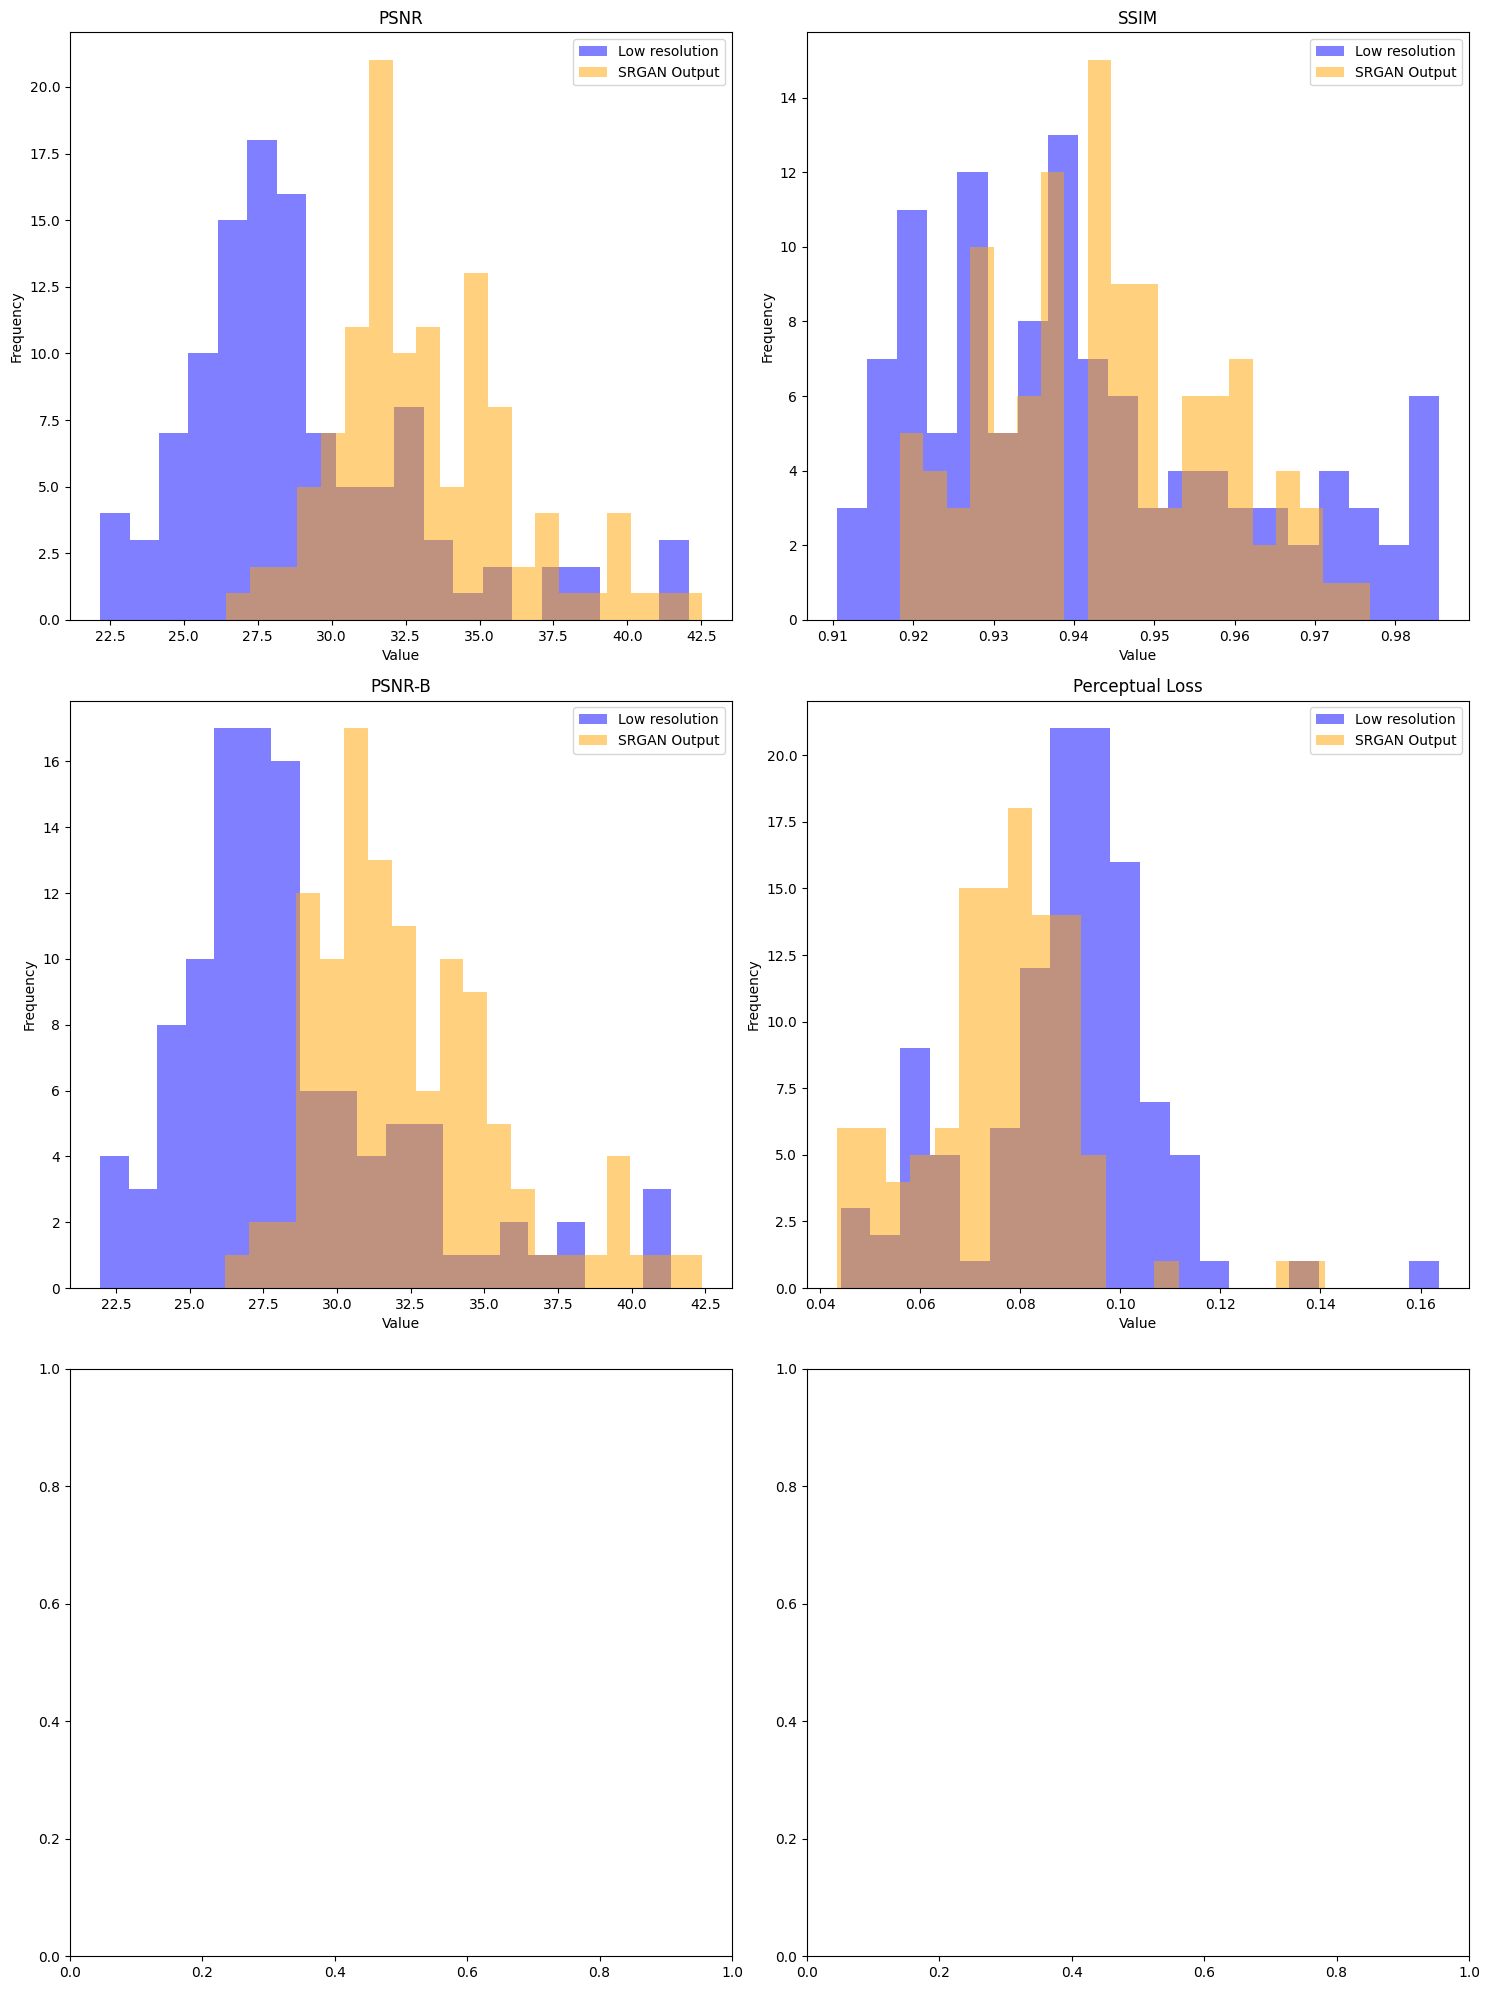

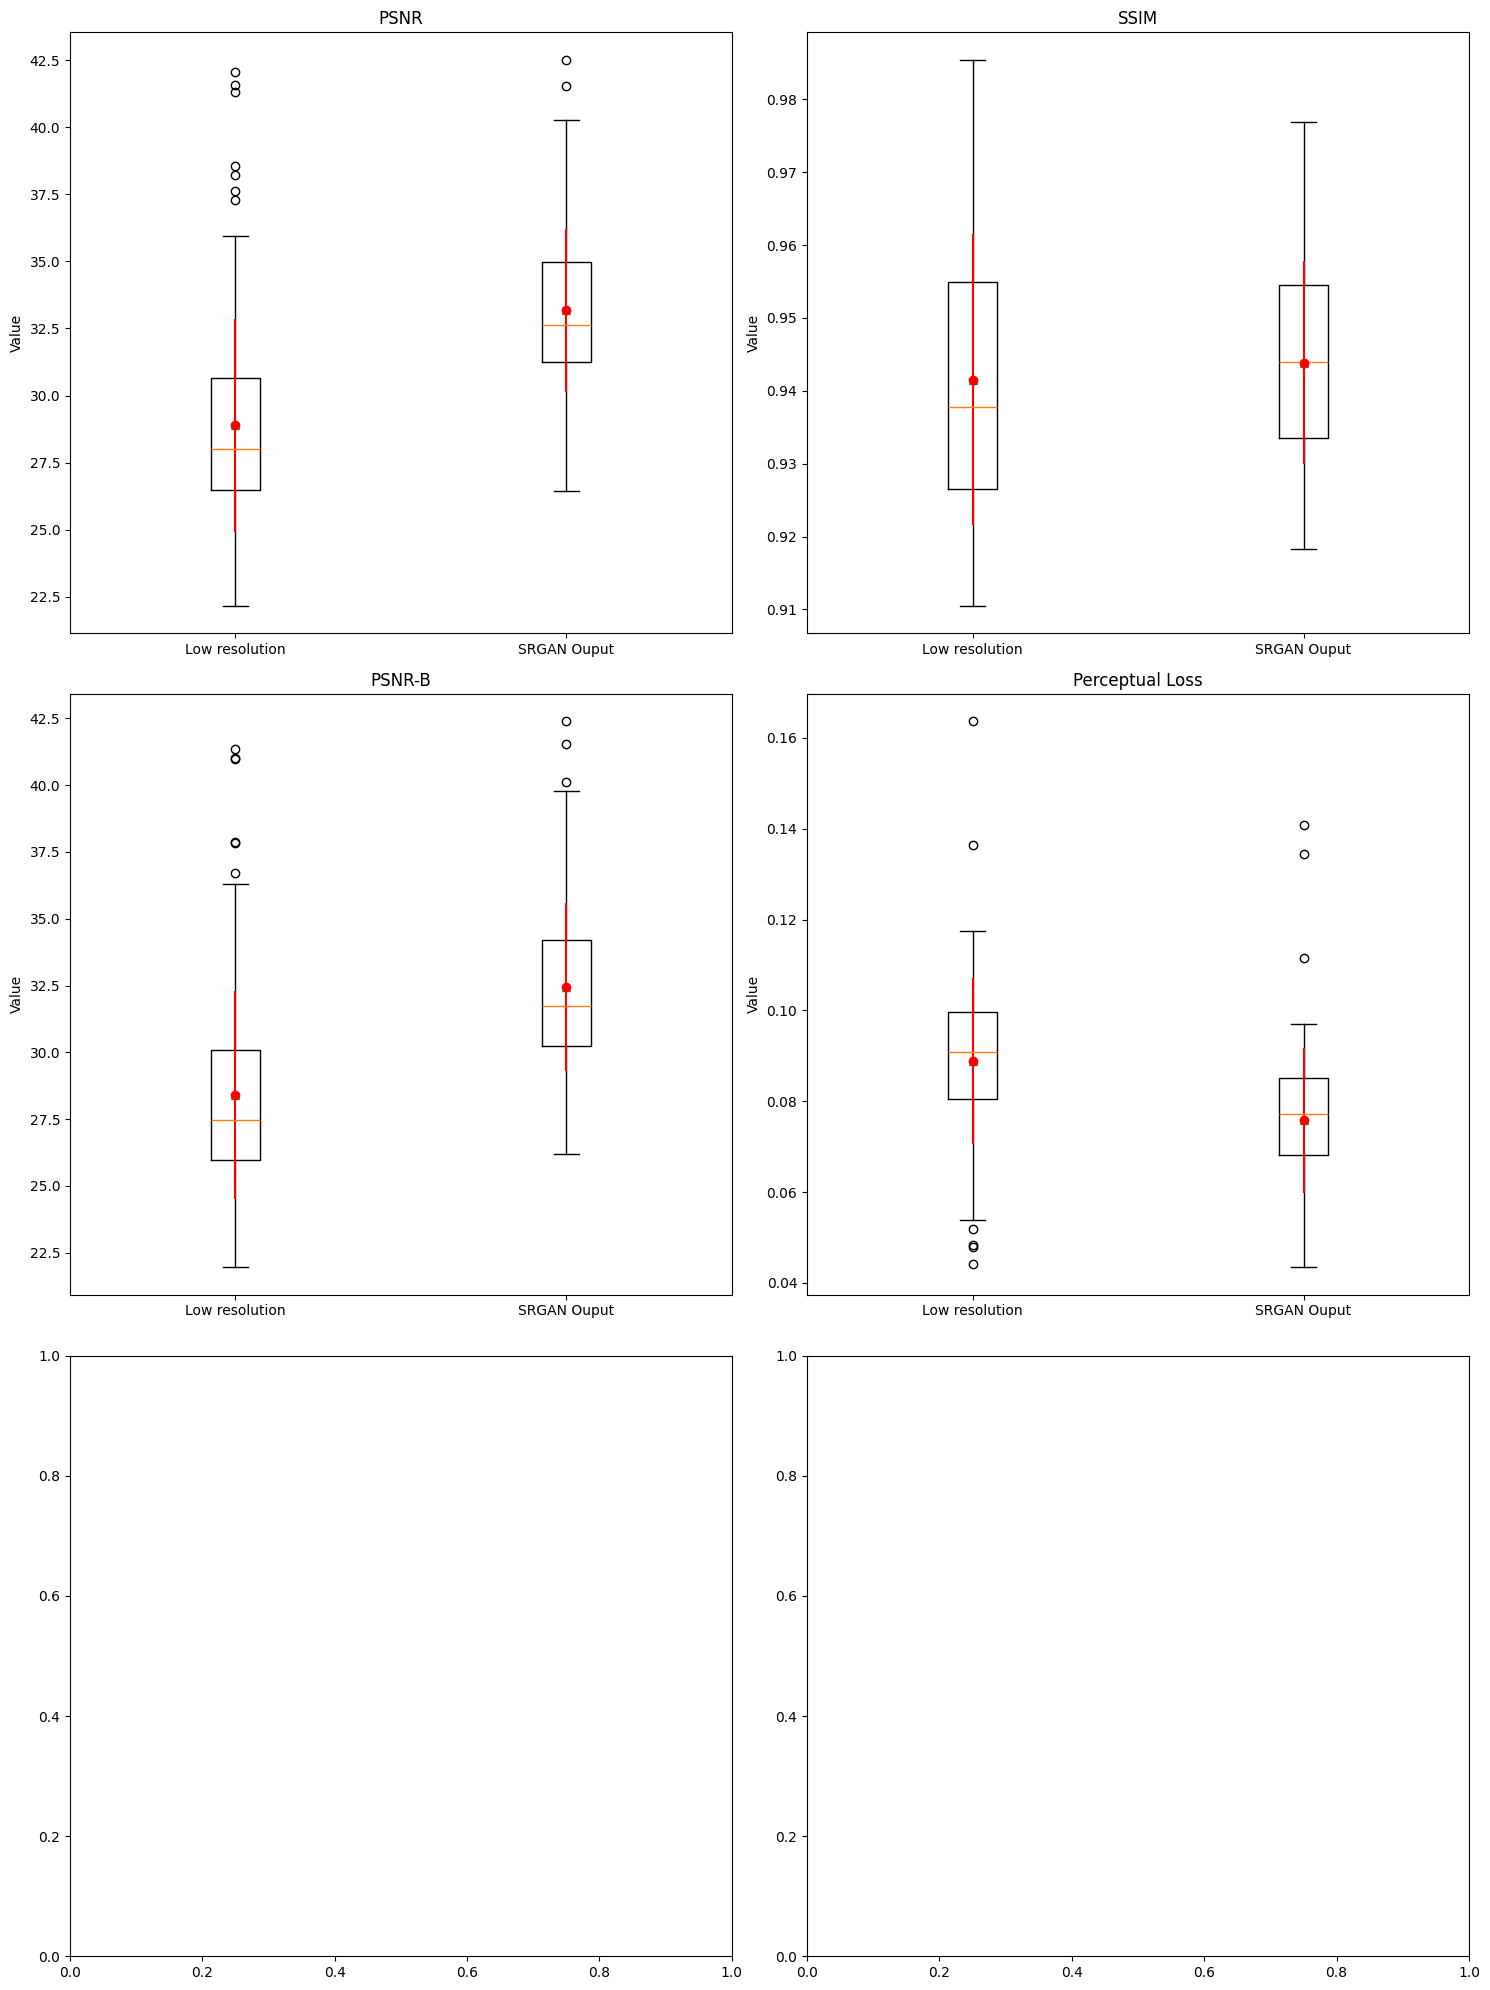

In [68]:
test(generator, val_dataloader)